# Fitting polynomials to terrain data

This notebook uses `tools.py` to fit a polynomial of degree 5 to terrain data from Norway with OLS, Ridge and Lasso, and analyses the resulting fit using the resampling methods of K-fold-validation and Bootstrap.

We start with some mandatory jupyter magic and imports

In [389]:
%matplotlib  inline
%load_ext autoreload
%autoreload 2

import tools
import plotting
import numpy as np
import matplotlib.pyplot as plt


from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output
from franke import FrankeFunction, FrankePlot

plt.rcParams.update({'font.size': 16})
figure_dir = 'figures/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Disable this if you don't want to save the plots:

In [25]:
save_fig = True

# Load the terrain

In [297]:
from imageio import imread

terrain = np.array(imread('course_project1/DataFiles/SRTM_data_Norway_2.tif')).astype(np.float64)
terrain = terrain/np.max(terrain)
[n,m] = terrain.shape

# Pick out and show patches

0.01 0.78
0.01 0.78
0.01 0.78
0.01 0.78
0.01 0.78
0.01 0.78


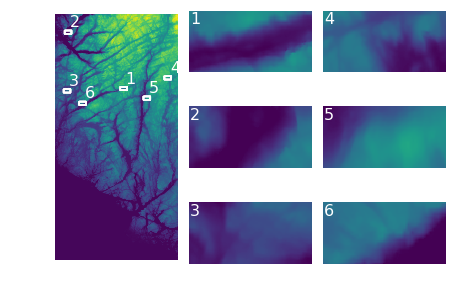

In [366]:
# fig,ax = plt.subplots(1,figsize = [7,6])
fig = plt.figure(figsize = [7,5])

ax = plt.subplot2grid((1, 6), (0, 0), rowspan=1,colspan=2)
n_patches = 6
axes = [plt.subplot2grid((3, 6), (i%3, 2+(2*(i//3))), rowspan=1, colspan=2) for i in range(n_patches)]
m = ax.imshow(terrain, interpolation = 'nearest')

np.random.seed(1)
n_col = 100
n_row = 50
n,m = terrain.shape
row_start = np.random.randint(0,n, n_patches)
col_start = np.random.randint(0,m, n_patches)

max_val = np.max(terrain)

for i, (c0, r0) in enumerate(zip(col_start, row_start)):
    patch = terrain[r0:r0+n_row, c0:c0+n_col]
    
    # ensure non-water areas
    while np.mean(patch) < 0.1:
        r0 = np.random.randint(0, n)
        c0 = np.random.randint(0, m)
        col_start[i] = c0
        row_start[i] = r0
        patch = terrain[r0:r0+n_row, c0:c0+n_col]
    patch_col, patch_row = np.c_[c0:c0+n_col], np.c_[r0:r0+n_row]

    mat = np.zeros_like(terrain)
    mat[r0:r0+n_row, c0:c0+n_col] = 1
    ax.contour(mat, colors = 'w', extent = [0,m,0,n])
    j = i+1
    ax.text(c0+80,r0-50, j, color = 'w')
    axes[i].imshow(patch,vmax=1, extent = [c0, c0+n_col, r0, r0 + n_row])
    
plotting.add_letters_to_axes(axes, '123456', pos = [0.01,0.78], color = 'w')
ax.axis('off')
[a.axis('off') for a in axes]
    
if save_fig:
    fig.savefig(figure_dir + 'terrain_data.pdf')

## Fitting the model to terrain data

In [323]:
from scipy.interpolate import interp2d

#def ground_truth_terrain(x_grid,y_grid,patch):
def ground_truth_terrain(patch):
    n_row, n_col= patch.shape
    # interp = interp2d(y_grid,x_grid,patch)
    def terrain_truth(x,y):
        return patch[ (y*n_row).astype(np.int64), (x*n_col).astype(np.int64)]
        # return np.array([a(y_,x_) for x_,y_ in zip(x,y)]) # :(
    return  terrain_truth

In [649]:
#degrees = np.arange(5, 21)
#lambda_values = np.logspace(-7, -2, 11)
degrees = np.arange(5, 17)
lambda_values = np.logspace(-7, -2, 6)

n_poly = degrees.size
n_lmbd = lambda_values.size
n_fold = 10 # 50
n_solvers = 3


# This is madness!
mse = np.zeros((n_patches,n_poly, n_lmbd, n_solvers, n_fold))
r2  = np.zeros((n_patches,n_poly, n_lmbd, n_solvers, n_fold))

# Define their axes
rows = np.arange(0,1,1/n_row)
cols = np.arange(0,1,1/n_col)

[C,R] = np.meshgrid(cols,rows)

x = C.reshape(-1,1).squeeze()
y = R.reshape(-1,1).squeeze()


n_patches * degrees.size * lambda_values.size * n_fold
N = m*n

def simple_stat(*args):
    """For k-fold"""
    regr, z_test, _, design_test, _ = args
    
    z_pred_test = regr.predict(design_test)
    
    r2_test   = tools.r2score(z_test, z_pred_test)
    mse_test  = tools.squared_error(z_test, z_pred_test)
    return r2_test, mse_test

# THIS... IS... SPARTA!!!!
for i, (r0, c0) in enumerate(zip(row_start, col_start)): # n_patches
    for j,deg in enumerate(degrees):                     # n_poly
        for k, lmbd in enumerate(lambda_values):         # n_lmbd
            row_end = row_start + n_row
            col_end = col_start + n_col

            patch = terrain[r0:r0+n_row, c0:c0 + n_col]
            
            z = patch.reshape(-1,1).squeeze()
            X = tools.get_X_poly2D(x,y, deg = deg)
            for a, method in enumerate(['ols','ridge','lasso']):
            #for a, method in enumerate(['lasso']):
                if method == 'ols' and k > 0:
                    continue
                clear_output(wait = True)
                print('{}/{}  {}/{}  {}/{}  {}/{}'.format(i+1,n_patches,
                                                         j+1, n_poly,
                                                         k+1, n_lmbd,
                                                         a+1, n_solvers))
                
                lmbd_in = lmbd if method != 'ols' else 0
                out = tools.k_fold_val(x, y, z, statistic_func = simple_stat, deg = deg,
                                       lmbd = lmbd_in, method = method, return_average = False,
                                          k = n_fold,  solve_method = 'svd')
                r2[i,j,k,a] = out[:,0]
                mse[i,j,k,a] = out[:,1]
                

6/6  12/12  6/6  1/1


# Save data

In [669]:
save_data = True

if save_data:
    np.save('data/mse_terrain.npy', mse)
    np.save('data/r2_terrain.npy', r2)

# Load data

In [676]:
load_data = True

if load_data:
    mse = np.load('data/mse_terrain.npy')
    r2 = np.load('data/r2_terrain.npy')

# Structure in pandas dataframe

In [948]:
def find_best_params(mean, std):
    i_min = np.argmin(mean)  
    ind = np.unravel_index(i_min, mean.shape)
    # ind = (i_min % n, i_min // n)
    
    opt_mean = mean[ind[0], ind[1]]
    opt_std  = std[ind[0], ind[1]]
    return opt_mean, opt_std, ind
    
    
    
import pandas as pd

columns = {}
solvers = ['ols','ridge','lasso']

cols = pd.MultiIndex.from_product([solvers, ['mean','std','poly','lmbd','r2_mean']], 
                                             names=['solver',''])
opt_val = pd.DataFrame(columns = cols) 
opt_val.index.name = 'patch_number'

mse_mean = np.mean(mse, axis = -1)
mse_std = np.std(mse, axis = -1)

r2_mean = np.mean(r2, axis = -1)
r2_std = np.std(r2, axis = -1)

for i in range(n_patches):
    for a,method in enumerate(solvers):
        opt_mean, opt_std, ind = find_best_params(mse_mean[i, :, :, a], mse_std[i, :, :, a])
        opt_val.loc[i+1,(method,'mean')] = opt_mean
        opt_val.loc[i+1,(method,'r2_mean')] = r2_mean[i,ind[0], ind[1],a]
        # opt_val.loc[i+1,(method,'r2_std')] = r2_std[i,ind[0], ind[1],a]
        opt_val.loc[i+1,(method,'std')]  = opt_std
        opt_val.loc[i+1,(method,'poly')] = degrees[ind[0]]
        opt_val.loc[i+1,(method,'lmbd')] = lambda_values[ind[1]] if method != 'ols' else 0
    
opt_val = opt_val.apply(pd.to_numeric)#['best_solver'] = opt_val.apply()
best_solvers = opt_val.swaplevel(0,1,axis=1)['mean'].idxmin(axis=1)
print('best solvers:')
print(best_solvers)
opt_val

best solvers:
patch_number
1    ridge
2    ridge
3    ridge
4    ridge
5    ridge
6    ridge
dtype: object


solver             ols                                   ridge                 \
                  mean       std poly lmbd   r2_mean      mean       std poly   
patch_number                                                                    
1             0.001075  0.001048    7    0  0.788438  0.000682  0.000352   11   
2             0.000842  0.001221    8    0  0.935714  0.000584  0.000523    9   
3             0.000516  0.000244    5    0  0.789983  0.000431  0.000268   15   
4             0.000754  0.000768    7    0  0.673079  0.000615  0.000270    8   
5             0.000283  0.000142    7    0  0.982420  0.000258  0.000093    7   
6             0.000750  0.000852    8    0  0.643720  0.000488  0.000375   13   

solver                                   lasso                           \
                      lmbd   r2_mean      mean       std poly      lmbd   
patch_number                                                              
1             1.000000e-06  0.867072  0.002611  0.002422   14  0.000001   
2             1.000000e-07  0.964918  0.001721  0.000734   15  0.000001   
3             1.000000e-04  0.828470  0.000773  0.000577    7  0.000001   
4             1.000000e-03  0.709764  0.001083  0.000619   16  0.000010   
5             1.000000e-07  0.984323  0.000776  0.000333   16  0.000001   
6             1.000000e-05  0.809853  0.001585  0.000827   11  0.000001   

solver                  
               r2_mean  
patch_number            
1             0.500143  
2             0.893610  
3             0.740267  
4             0.509703  
5             0.956012  
6             0.452569

### Interesting plot
Here we compare the optimal penalty versus optimal polynomial degree. The different patches are colored equally in the two plots. Notice the inverse relationship of patch and optimal polynomial degree

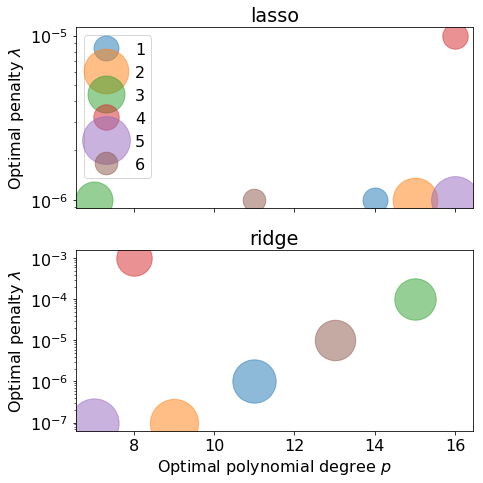

In [1025]:
fig,axes = plt.subplots(2,1,figsize = [7,7],sharex=True)

for ax,(method, item) in zip(axes, opt_val[['ridge','lasso']].stack().items()):
    
    item = item.unstack()
    

    for patch_i, sub_item in item.T.items():
        ax.plot(sub_item['poly'], sub_item['lmbd'], 'o', alpha = 0.5, markersize = 50*sub_item['r2_mean'],
               label = '{}'.format(patch_i))
        # ax.text(sub_item['poly']+0.1, sub_item['lmbd']*1.1 , s = patch_i)

    # if method != 'ols':
    ax.set_yscale("log", nonposy='clip') 
    ax.set_title(method)
    ax.set_ylabel('Optimal penalty $\lambda$')
    
axes[0].legend()
axes[-1].set_xlabel('Optimal polynomial degree $p$')
fig.tight_layout()
plt.savefig(figure_dir + 'optimal_compare.pdf')

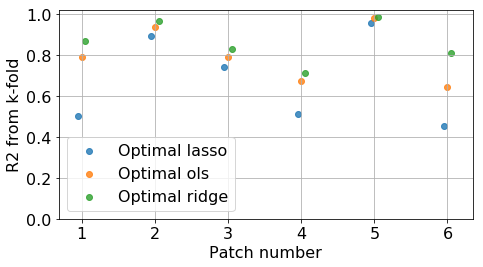

In [932]:
fig,ax = plt.subplots(1,1, figsize = [7,4])


for i, (marker, (method, item)) in enumerate(zip('ooo', opt_val.stack().items())):
    item = item.unstack()
    ax.scatter(np.arange(n_patches)+0.95 + i*0.05, item['r2_mean'], alpha = 0.8,
               # s=60,marker=marker,
                label = 'Optimal {}'.format(method))

ax.grid()

ax.legend()
ax.set_xlabel('Patch number')
ax.set_ylim([0, ax.get_ylim()[1]])
ax.set_ylabel('R2 from k-fold')

plt.tight_layout()
plt.savefig(figure_dir + 'optimal_r2.pdf')

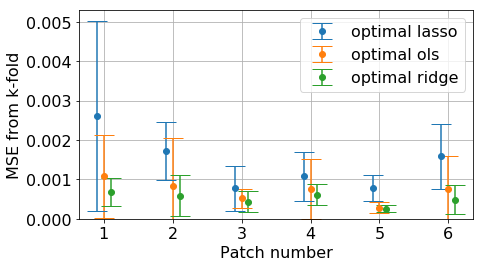

In [1028]:
fig,ax = plt.subplots(1,1, figsize = [7,4])


for i, (marker, (method, item)) in enumerate(zip('ooo', opt_val.stack().items())):
# for method, item in opt_val.stack().items():
    item = item.unstack()
    ax.errorbar(np.arange(n_patches)+0.9+ i*0.1, item['mean'], yerr = item['std'], capsize=10, lolims=0,
                 fmt='o', label = 'optimal {}'.format(method))

ax.grid()

ax.legend()
ax.set_xlabel('Patch number')
ax.set_ylim([0, ax.get_ylim()[1]])
ax.set_ylabel('MSE from k-fold')

plt.tight_layout()
plt.savefig(figure_dir + 'optimal_error.pdf')

# Visualize the fits

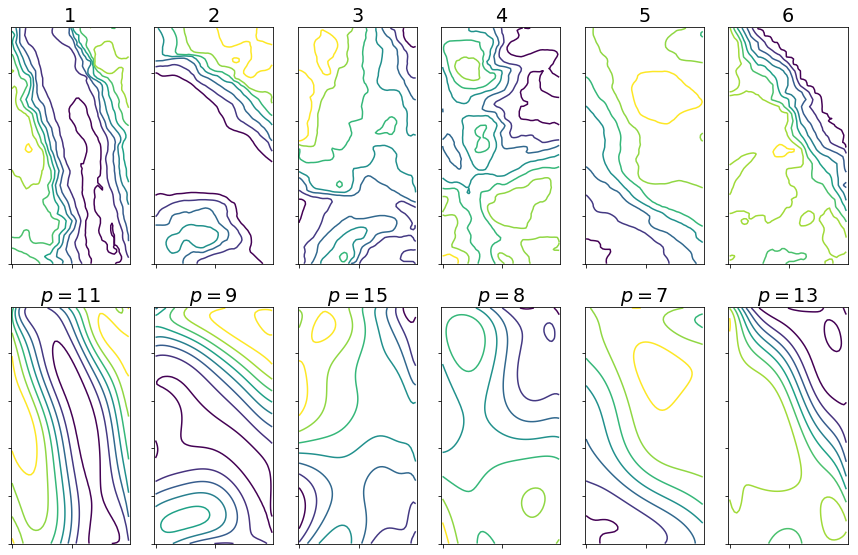

In [1029]:

fig, [ax_up,ax_down] = plt.subplots(2,6, figsize = [12.2, 8])
for i in range(n_patches):
    c0 = col_start[i]
    r0 = row_start[i]
    
    best = best_solvers.loc[i+1]
    deg  = opt_val.loc[i+1,(best,'poly')]
    lmbd = opt_val.loc[i+1,(best,'lmbd')]
    
    patch = terrain[r0:r0+n_row, c0:c0 + n_col]

    X = tools.get_X_poly2D(x,y, deg = int(deg))
    z = patch.reshape(-1,1).squeeze()
    
    # fuck lasso
    regr = tools.Regression(X,z, lmbd = lmbd)
    
    z_pred = regr.predict(X)
    predict_patch = z_pred.reshape(n_row, n_col)
    
    
    ax_up[i].contour(patch.T)
    ax_down[i].contour(predict_patch.T)
    
    ax_up[i].set_title('%d' % (i+1))
    ax_down[i].set_title('$p = %d$' % (deg))
    ax_up[i].set_xticklabels([])
    ax_up[i].set_yticklabels([])
    ax_down[i].set_xticklabels([])
    ax_down[i].set_yticklabels([])
    ax_up[i].axis('equal')
    ax_down[i].axis('equal')
    
fig.tight_layout()
if save_fig:
    fig.savefig(figure_dir + 'visualize_fit.pdf')

In [967]:

patch.shape, (n_col, n_row)

((100, 50), (100, 50))

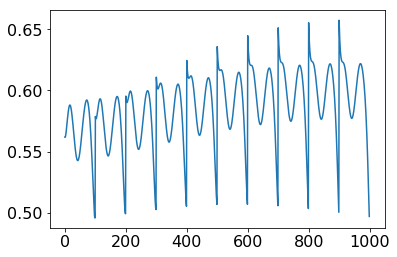

In [981]:
plt.plot(z_pred[:1000])

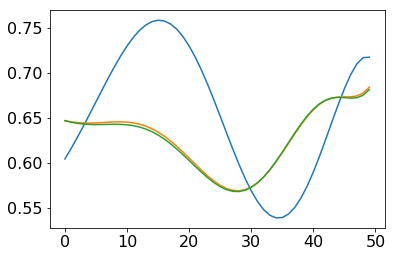

In [960]:
plt.plot(predict_patch[::2,0])
plt.plot(predict_patch[1::2,0])
plt.plot(predict_patch[::2,-1])

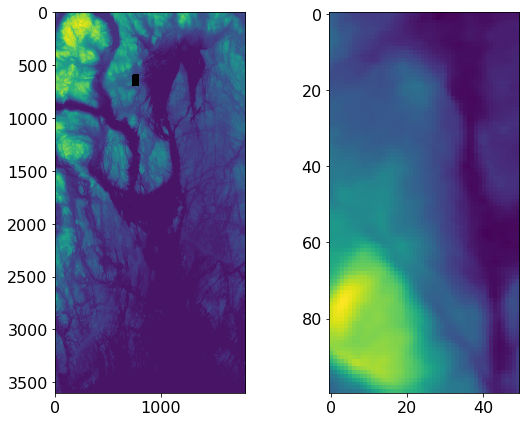

In [263]:
np.random.seed(23)
n_col = 50
n_row = 100
n,m = terrain.shape
r0 = np.random.randint(0,n)
c0 = np.random.randint(0,m)
# r0 = 700

patch = terrain[r0:r0+n_row, c0:c0+n_col]
patch_col, patch_row = np.c_[c0:c0+n_col:4], np.c_[r0:r0+n_row:4]

C, R = np.meshgrid(patch_col, patch_row)

fig,[ax1,ax2] = plt.subplots(1,2,figsize = [9,7])
m = ax1.imshow(terrain)
ax1.pcolormesh(C,R,np.ones_like(C), color = 'k')
m.set_cmap('viridis')

ax2.imshow(patch, cmap = 'viridis')

In [30]:
# Load the terrain
from imageio import imread

terrain = np.array(imread('data/n59_e010_1arc_v3.tif')).astype(np.float64)
terrain = terrain/np.max(terrain)
[n,m] = terrain.shape
from scipy.interpolate import interp2d

#def ground_truth_terrain(x_grid,y_grid,patch):
def ground_truth_terrain(patch):
    n_row, n_col= patch.shape
    # interp = interp2d(y_grid,x_grid,patch)
    def terrain_truth(x,y):
        return patch[ (y*n_row).astype(np.int64), (x*n_col).astype(np.int64)]
        # return np.array([a(y_,x_) for x_,y_ in zip(x,y)]) # :(
    return  terrain_truth

plt.imshow()

In [30]:
# Load the terrain
from imageio import imread

terrain = np.array(imread('data/n59_e010_1arc_v3.tif')).astype(np.float64)
terrain = terrain/np.max(terrain)
[n,m] = terrain.shape
from scipy.interpolate import interp2d

#def ground_truth_terrain(x_grid,y_grid,patch):
def ground_truth_terrain(patch):
    n_row, n_col= patch.shape
    # interp = interp2d(y_grid,x_grid,patch)
    def terrain_truth(x,y):
        return patch[ (y*n_row).astype(np.int64), (x*n_col).astype(np.int64)]
        # return np.array([a(y_,x_) for x_,y_ in zip(x,y)]) # :(
    return  terrain_truth

plt.imshow()

In [154]:
from IPython.display import clear_output
lmbd_ridge = 0.06
    
var = defaultdict(list)
bias_sq = defaultdict(list)
degrees = np.arange(8, 11, 1)
lmbd_opt = []

ground_truth = ground_truth_terrain(patch)
for deg in degrees:
    clear_output(wait = True)
    print('degree {}'.format(deg))
    v_ols, b_ols = tools.get_bias_and_variance(x,y,z,ground_truth = ground_truth, method = 'ols', lmbd = 0, deg = deg, solve_method='svd')
    sum_min = np.inf
    v_ridg_min = 0
    b_ridg_min = 0
    lmbd_min = np.inf
    for lmbd_ridge in np.logspace(-8,-4,5):
        print(lmbd_ridge)
        v_temp, b_temp = tools.get_bias_and_variance(x,y,z,ground_truth = ground_truth, 
                                                     method = 'ridge', lmbd = lmbd_ridge ,  
                                                     deg = deg, solve_method = 'svd')
        if v_temp+b_temp < sum_min:
            v_ridg_min = v_temp
            b_ridg_min = b_temp
            sum_min = v_temp+b_temp
            lmbd_min = lmbd_ridge
            print('Better! {}+{} < {}+{}'.format(v_temp, b_temp, v_ols, b_ols)) if sum_min < v_ols + b_ols else None
    # var, bias_sq = tools.get_bias_and_variance(x,y,z,, method='ridge', lmbd=0)
    var['ols'].append(v_ols)
    var['ridge'].append(v_ridg_min)
    bias_sq['ols'].append(b_ols)
    bias_sq['ridge'].append(b_ridg_min)
    lmbd_opt.append(lmbd_min)
print('Done')

degree 10
1e-08
Better! 0.00011266514909064939+0.0020860316523384063 < 0.0007806883851050433+0.02187137714382717
1e-07
1e-06
1e-05
0.0001
Done


In [147]:

noise = 0.1
seed = 3
lmbd_ridge = 0.005
    
var = defaultdict(list)
bias_sq = defaultdict(list)
degrees = np.arange(5,15, 1)

ground_truth = ground_truth_terrain(patch)
for deg in degrees:
    #clear_output(wait = True)
    print('degree {}'.format(deg))
    v_ols, b_ols = tools.get_bias_and_variance(x,y,z,ground_truth = ground_truth, method = 'ols', lmbd = 0, deg = deg)
    v_rid, b_rid = tools.get_bias_and_variance(x,y,z,ground_truth = ground_truth, method = 'ridge', lmbd = lmbd_ridge ,  deg = deg)
    # var, bias_sq = tools.get_bias_and_variance(x,y,z,, method='ridge', lmbd=0)
    var['ols'].append(v_ols)
    var['ridge'].append(v_rid)
    bias_sq['ols'].append(b_ols)
    bias_sq['ridge'].append(b_rid)
print('Done')

degree 5
degree 6
degree 7
degree 8
degree 9
degree 10
degree 11
degree 12
degree 13
degree 14
Done


In [148]:
bias_sq['ridge']
lmbd_opt

[1.0,
 1e-05,
 0.0001291549665014884,
 0.0004641588833612782,
 0.0016681005372000592]

0.01 0.9
0.01 0.9


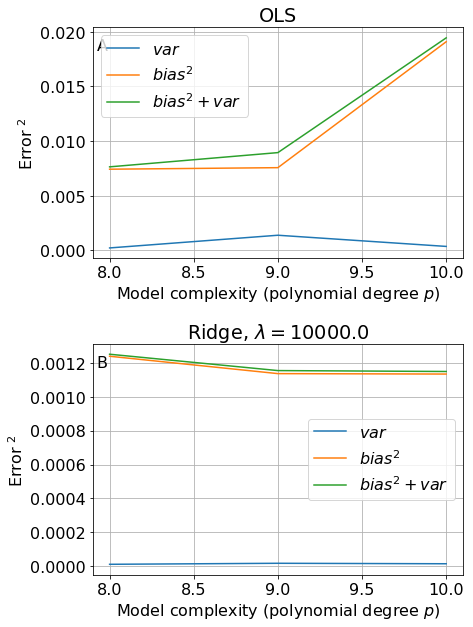

In [152]:
fig,[ax1,ax2] = plt.subplots(2,1, figsize = [7,9], sharex=False)
#fig,ax = plt.subplots(1,1, figsize = [7,9], sharex=False)
# ax1 = ax2 = ax
ax1.set_title('OLS')
ax1.plot(degrees, var['ols'])
ax1.plot(degrees, bias_sq['ols'])
ax1.plot(degrees, np.array(var['ols']) + bias_sq['ols'])

ax2.set_title('Ridge, $\lambda = {}$'.format(lmbd_ridge))
ax2.plot(degrees, var['ridge'])
ax2.plot(degrees, bias_sq['ridge'])
ax2.plot(degrees, np.array(var['ridge']) + bias_sq['ridge'])

lim = [ax2.get_xlim(), ax2.get_ylim()]
ax2.plot(degrees, np.array(var['ols']) + bias_sq['ols'], 'k--', alpha = 0.2)
ax2.set_xlim(lim[0]); ax2.set_ylim(lim[1])

for ax in (ax1,ax2):
    ax.set_ylabel('Error $^2$')
    ax.set_xlabel('Model complexity (polynomial degree $p$)')
    ax.grid()
    ax.legend(['$var$', '$bias^2$ ', '$bias^2 + var$'])
    
fig.tight_layout()
plotting.add_letters_to_axes([ax1,ax2])

# if save_fig:
    # fig.savefig(figure_dir + 'bias_variance.pdf')

In [153]:
lmbd_opt

[0.01, 0.01, 0.01]

In [15]:
[print((k+1)*(k+2)/2) for k in [5,25]]

21.0
351.0


[None, None]

In [362]:
def get_bias_and_variance_terrain(patch, ground_truth=FrankeFunction, method = 'ols', solve_method = 'svd', lmbd = 0, deg = 5):
    """Uses a combination of k-fold (k=50) and bootstrap (50 repetitions)
    to estimate bias and variance. Access to ground truth data, i.e.
    without noise, is necessary."""

    n_row, n_col = patch.shape
    
    row_index = np.arange(n_row)
    col_index = np.arange(n_col)
    rows = np.arange(0,1,1/n_row)
    cols = np.arange(0,1,1/n_col)

    [C,R] = np.meshgrid(cols,rows)

    x = C.reshape(-1,1).squeeze()
    y = R.reshape(-1,1).squeeze()


    def bias_var_return_values(regr, z_test, z_train, design_test, design_train):

        """Specifies the return values in the k_fold-validation as x,y,z_pred"""
        x_train, y_train = design_train[:,2], design_train[:,1]
        x_test, y_test = design_test[:,2], design_test[:,1]
        z_pred = bootstrap_predict_point(x_train, y_train, z_train, 
                x0 = x_test, y0 = y_test, deg = deg, rep = 20, lmbd=lmbd, 
                method = method, solve_method = solve_method)

        return np.array(z_pred), x_test, y_test, z_test

    # k = 50 gives 98% training and 2% test
    ret = k_fold_val(x, y, z,statistic_func=bias_var_return_values, k = 10, deg = deg, method = method,
                           solve_method = solve_method, return_average = False, lmbd = lmbd)

    z_pred = np.concatenate(ret[:,0], axis = 1) 
    x_test = np.concatenate(ret[:,1], axis = 0)
    y_test = np.concatenate(ret[:,2], axis = 0)
    z_test = np.concatenate(ret[:,3], axis = 0)

    z_pred_mean = np.mean(z_pred, axis = 0)
    var = np.mean(np.var(z_pred,axis = 0))
    print(np.mean(z_pred_mean))
    print(ground_truth(x_test,y_test))
    bias_squared = np.mean((ground_truth(x_test,y_test) - z_pred_mean)**2)
    return var, bias_squared, x_test, y_test, z_test, z_pred


In [367]:
# def get_bias_and_variance_terrain(patch, ground_truth=FrankeFunction, 
method = 'ols'
solve_method = 'svd'
lmbd = 0
deg = 5
n_row, n_col = patch.shape

row_index = np.arange(n_row)
col_index = np.arange(n_col)
rows = np.arange(0,1,1/n_row)
cols = np.arange(0,1,1/n_col)

[C,R] = np.meshgrid(cols,rows)

x = C.reshape(-1,1).squeeze()
y = R.reshape(-1,1).squeeze()
z = patch.reshape(-1,1).squeeze()


def bias_var_return_values(regr, z_test, z_train, design_test, design_train):

    """Specifies the return values in the k_fold-validation as x,y,z_pred"""
    x_train, y_train = design_train[:,2], design_train[:,1]
    x_test, y_test = design_test[:,2], design_test[:,1]
    z_pred = tools.bootstrap_predict_point(x_train, y_train, z_train, 
            x0 = x_test, y0 = y_test, deg = deg, rep = 20, lmbd=lmbd, 
            method = method, solve_method = solve_method)

    return np.array(z_pred), x_test, y_test, z_test

# k = 50 gives 98% training and 2% test
ret = tools.k_fold_val(x, y, z,statistic_func=bias_var_return_values, k = 10, deg = deg, method = method,
                       solve_method = solve_method, return_average = False, lmbd = lmbd)

z_pred = np.concatenate(ret[:,0], axis = 1) 
x_test = np.concatenate(ret[:,1], axis = 0)
y_test = np.concatenate(ret[:,2], axis = 0)
z_test = np.concatenate(ret[:,3], axis = 0)

z_pred_mean = np.mean(z_pred, axis = 0)
var = np.mean(np.var(z_pred,axis = 0))
print(np.mean(z_pred_mean))
print(ground_truth(x_test,y_test))
bias_squared = np.mean((ground_truth(x_test,y_test) - z_pred_mean)**2)
# return var, bias_squared, x_test, y_test, z_test, z_pred

209.389773285
[[  77.        ]
 [  75.06568486]
 [  74.6976587 ]
 ..., 
 [ 131.99201321]
 [ 128.73804086]
 [ 127.00171611]]


In [380]:
z_pred_mean = np.mean(z_pred, axis = 0)
var = np.mean(np.var(z_pred,axis = 0))
ground_truth = f

print(np.mean(z_pred_mean))
print(ground_truth(x_test,y_test))
bias_squared = np.mean((ground_truth(x_test,y_test) - z_pred_mean)**2)
var, bias_squared, x_test, y_test, z_test, z_pred

209.389773285
[[  77.        ]
 [  75.06568486]
 [  74.6976587 ]
 ..., 
 [ 131.99201321]
 [ 128.73804086]
 [ 127.00171611]]


(11.041934975297995,
 1899.6470228916337,
 array([ 0.  ,  0.02,  0.04, ...,  0.94,  0.96,  0.98]),
 array([ 0.  ,  0.  ,  0.  , ...,  0.99,  0.99,  0.99]),
 array([ 109.,  120.,  139., ...,  106.,  106.,  105.]),
 array([[ 221.9798304 ,  232.54802037,  241.9523689 , ...,  385.37166624,
          424.20597558,  468.07115664],
        [ 236.3256813 ,  245.7113044 ,  254.07741996, ...,  373.46151776,
          411.74685872,  454.97931665],
        [ 220.22510582,  231.54739045,  241.65302292, ...,  421.76064767,
          466.15022164,  516.21370307],
        ..., 
        [ 269.92766905,  275.94497934,  281.31655084, ...,  360.27679468,
          397.39569728,  439.39710909],
        [ 231.9685289 ,  240.6842206 ,  248.62595476, ...,  405.13045458,
          447.61393868,  495.52263513],
        [ 261.93770549,  268.01934903,  273.48749042, ...,  382.91135764,
          423.09614665,  468.46628108]]))

In [378]:
%matplotlib

Using matplotlib backend: Qt5Agg


In [381]:
ground_truth = ground_truth_terrain(patch)
fig = plt.figure(figsize = [8,4])
ax = fig.gca(projection='3d')
ax.scatter(x_test, y_test, z_test, s=1)
# ax.scatter(x_test, y_test, z_pred_mean, s=1)
ax.scatter(x_test, y_test, ground_truth(y_test,x_test), s=1)
ax.view_init(30,5)

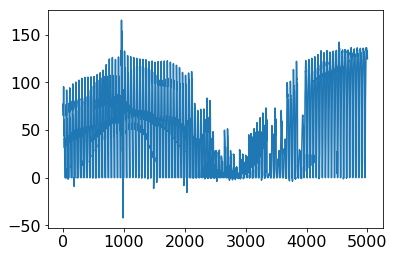

In [348]:

plt.plot(ground_truth(x_test,y_test))

In [259]:
np.sqrt(35672.844782)

188.87256227943752

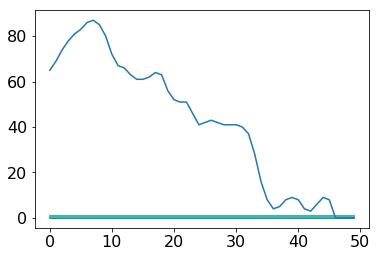

In [239]:

plt.plot(f(x[10*50:11*50],y[10*50:11*50]))
plt.plot(z[10*50:11*50])

In [226]:
C.shape, R.shape, patch.shape

((100, 50), (100, 50), (100, 50))

In [230]:
a = interp2d(x, y, patch)

/home/halvard/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=64,83 m=5000 fp=419.600042 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [256]:
np.array([a(x_,y_) for x_,y_ in zip(x,y)])

array([[  77.        ],
       [  76.        ],
       [  78.        ],
       ..., 
       [ 117.42831282],
       [ 121.45610982],
       [ 124.67196069]])

In [197]:
# var, np.sqrt(bias_sq)
f = ground_truth_terrain(x_mesh, y_mesh, patch)
plt.figure()
plt.imshow(f(x,y).reshape(patch_size_row,patch_size_col)) 
plt.figure()
plt.imshow(z.reshape(patch_size_row,patch_size_col)) 


/home/halvard/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=97,55 m=5000 fp=64.862885 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


ValueError: cannot reshape array of size 25000000 into shape (100,50)

In [11]:
# Perform fit over the whole dataset
print("The whole dataset")

rows = np.linspace(0,1,n)
cols = np.linspace(0,1,m)

[C,R] = np.meshgrid(cols,rows)

x = C.reshape(-1,1)
y = R.reshape(-1,1)

num_data = n*m

data = tools.get_X_poly2D(x,y, deg = 5)

z = terrain.flatten()

beta_ols = np.linalg.inv(data.T @ data) @ data.T @ z

fitted_terrain = predict(rows, cols, beta_ols)

mse = np.sum( (fitted_terrain - terrain)**2 )/num_data
R2 = 1 - np.sum( (fitted_terrain - terrain)**2 )/np.sum( (terrain- np.mean(terrain))**2 )
var = np.sum( (fitted_terrain - np.mean(fitted_terrain))**2 )/num_data
bias = np.sum( (terrain - np.mean(fitted_terrain))**2 )/num_data

print("mse: %g\nR2: %g"%(mse, R2))
print("variance: %g"%var)
print("bias: %g\n"%bias)

plt.show()

OSError: No such file: '/home/halvard/uio/fys-stk4155_machinelearning/project1/data/SRTM_data_Norway_1.tif'

ValueError: shape mismatch: objects cannot be broadcast to a single shape

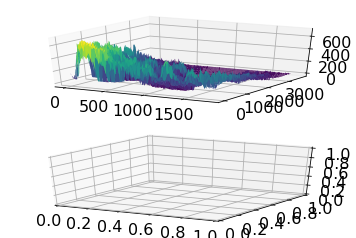

In [18]:
# plot_terrain()
m,n = data.shape

xmesh = np.arange(n)
ymesh = np.arange(m)

[x,y] = np.meshgrid(xmesh, ymesh)


fig = plt.figure()
ax1 = fig.add_subplot(211,projection='3d')
ax2 = fig.add_subplot(212,projection='3d')
ax1.plot_surface(x,y,data,cmap=plt.cm.viridis,linewidth=0)
ax2.plot_surface(x,y,zpred,cmap=plt.cm.viridis,linewidth=0)

# ax = fig.add_subplot(212)
# ax.pcolormesh(x,y,data,cmap=cm.viridis,linewidth=0)
plt.show()


Generating the data is handily provided by `tools.generate_data`, and subsequent model generation is done by creating the design matrix and feeding it to `tools.Regression` for OLS and Ridge regression. $\lambda$ is the penalty in the Ridge regression method, which reduces to OLS if $\lambda = 0$ 